# Trading Environment for Stock Trading

Gymnasium environment for RL-based stock trading with buy/sell/hold actions.


In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Optional, Tuple, Dict


## TradingEnv Class


In [2]:
class TradingEnv(gym.Env):
    """
    Trading environment for single stock trading.
    
    Actions: 0=Hold, 1=Buy (all-in), 2=Sell (all-out)
    Reward: Sharpe ratio (return / risk)
    """
    
    metadata = {"render_modes": ["human"], "render_fps": 4}
    
    def __init__(
        self,
        data_path: str,
        initial_balance: float = 10000.0,
        lookback_window: int = 30,
        render_mode: Optional[str] = None
    ):
        super().__init__()
        
        self.initial_balance = initial_balance
        self.lookback_window = lookback_window
        self.render_mode = render_mode
        
        # Load data
        self.data = self._load_data(data_path)
        self.data_length = len(self.data)
        
        # Trading state
        self.current_step = 0
        self.balance = initial_balance
        self.shares = 0
        self.position = 0  # 0: no position, 1: long position
        self.entry_price = 0.0
        
        # Track returns for Sharpe ratio
        self.returns_history = []
        self.portfolio_values = []
        
        # Action space: 0=hold, 1=buy, 2=sell
        self.action_space = spaces.Discrete(3)
        
        # Observation space: normalized prices, volume, returns, position info
        n_features = 8
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(lookback_window, n_features),
            dtype=np.float32
        )
        
        # Normalization parameters
        self.price_mean = None
        self.price_std = None
        self.volume_mean = None
        self.volume_std = None
        
        self._compute_normalization_params()
    
    def _load_data(self, data_path: str) -> pd.DataFrame:
        """Load and preprocess stock data."""
        df = pd.read_csv(data_path, sep=',')
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        df['Returns'] = df['Close'].pct_change().fillna(0)
        return df
    
    def _compute_normalization_params(self):
        """Compute normalization parameters from data."""
        self.price_mean = self.data[['Close', 'Open', 'High', 'Low']].mean().mean()
        self.price_std = self.data[['Close', 'Open', 'High', 'Low']].std().mean()
        self.volume_mean = self.data['Volume'].mean()
        self.volume_std = self.data['Volume'].std()
    
    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None
    ) -> Tuple[np.ndarray, Dict]:
        """Reset environment to initial state."""
        super().reset(seed=seed)
        
        # Start from a random point
        self.current_step = np.random.randint(
            self.lookback_window,
            self.data_length - 100
        )
        
        # Reset trading state
        self.balance = self.initial_balance
        self.shares = 0
        self.position = 0
        self.entry_price = 0.0
        self.returns_history = []
        self.portfolio_values = [self.initial_balance]
        self._recent_actions = []
        
        observation = self._get_observation()
        info = self._get_info()
        
        return observation, info
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Execute one step in the environment."""
        self._execute_action(action)
        self.current_step += 1
        
        terminated = self.current_step >= self.data_length - 1
        truncated = False
        
        reward = self._calculate_reward()
        observation = self._get_observation()
        info = self._get_info()
        
        return observation, reward, terminated, truncated, info
    
    def _execute_action(self, action: int):
        """Execute trading action."""
        current_price = self.data.iloc[self.current_step]['Close']
        
        if action == 1:  # Buy
            if self.position == 0:
                self.shares = self.balance / current_price
                self.balance = 0
                self.position = 1
                self.entry_price = current_price
                
        elif action == 2:  # Sell
            if self.position == 1:
                self.balance = self.shares * current_price
                self.shares = 0
                self.position = 0
                self.entry_price = 0.0
        
        # Track recent actions
        if not hasattr(self, '_recent_actions'):
            self._recent_actions = []
        self._recent_actions.append(action)
        if len(self._recent_actions) > 10:
            self._recent_actions.pop(0)
    
    def _get_portfolio_value(self) -> float:
        """Calculate current portfolio value."""
        if self.current_step >= len(self.data):
            current_price = self.data.iloc[-1]['Close']
        else:
            current_price = self.data.iloc[self.current_step]['Close']
        return self.balance + self.shares * current_price
    
    def _calculate_reward(self) -> float:
        """Calculate reward based on Sharpe ratio."""
        current_value = self._get_portfolio_value()
        self.portfolio_values.append(current_value)
        
        # Calculate returns
        if len(self.portfolio_values) > 1:
            daily_return = (current_value - self.portfolio_values[-2]) / self.portfolio_values[-2]
            self.returns_history.append(daily_return)
        
        # Early reward
        if len(self.returns_history) < 2:
            if len(self.returns_history) == 1:
                return self.returns_history[0] * 10
            return 0.0
        
        returns_array = np.array(self.returns_history)
        mean_return = np.mean(returns_array)
        std_return = np.std(returns_array)
        
        if std_return < 1e-8:
            return mean_return * 100
        
        # Sharpe ratio
        sharpe_ratio = mean_return / std_return
        recent_return = self.returns_history[-1] if self.returns_history else 0.0
        
        # Weighted reward: 70% Sharpe ratio, 30% recent return
        reward = (sharpe_ratio * 0.7 + recent_return * 10 * 0.3) * 0.1
        
        # Penalty for holding cash too long
        if self.position == 0 and len(self.returns_history) > 10:
            recent_actions = getattr(self, '_recent_actions', [])
            if len(recent_actions) > 5 and all(a == 0 for a in recent_actions[-5:]):
                reward -= 0.001
        
        return reward
    
    def _get_observation(self) -> np.ndarray:
        """Get current observation."""
        start_idx = max(0, self.current_step - self.lookback_window + 1)
        end_idx = self.current_step + 1
        
        window_data = self.data.iloc[start_idx:end_idx].copy()
        
        # Pad if necessary
        if len(window_data) < self.lookback_window:
            padding = self.lookback_window - len(window_data)
            first_row = window_data.iloc[0:1]
            padding_data = pd.concat([first_row] * padding, ignore_index=True)
            window_data = pd.concat([padding_data, window_data], ignore_index=True)
        
        # Normalize features
        normalized_close = (window_data['Close'] - self.price_mean) / (self.price_std + 1e-8)
        normalized_open = (window_data['Open'] - self.price_mean) / (self.price_std + 1e-8)
        normalized_high = (window_data['High'] - self.price_mean) / (self.price_std + 1e-8)
        normalized_low = (window_data['Low'] - self.price_mean) / (self.price_std + 1e-8)
        normalized_volume = (window_data['Volume'] - self.volume_mean) / (self.volume_std + 1e-8)
        returns = window_data['Returns'].values
        position_indicator = np.full(self.lookback_window, self.position)
        cash_ratio = (self.balance / self.initial_balance) * np.ones(self.lookback_window)
        
        # Stack features
        observation = np.column_stack([
            normalized_close.values,
            normalized_open.values,
            normalized_high.values,
            normalized_low.values,
            normalized_volume.values,
            returns,
            position_indicator,
            cash_ratio
        ]).astype(np.float32)
        
        return observation
    
    def _get_info(self) -> Dict:
        """Get additional information about current state."""
        return {
            "step": self.current_step,
            "balance": self.balance,
            "shares": self.shares,
            "position": self.position,
            "portfolio_value": self._get_portfolio_value(),
            "current_price": self.data.iloc[self.current_step]['Close']
        }
    
    def render(self):
        """Render environment."""
        if self.render_mode == "human":
            info = self._get_info()
            print(f"Step: {info['step']}, "
                  f"Portfolio: ${info['portfolio_value']:.2f}, "
                  f"Position: {info['position']}, "
                  f"Price: ${info['current_price']:.2f}")

print("TradingEnv class defined")


TradingEnv class defined


## Test Environment


In [1]:
# Find a data file
data_dir = Path('data')
data_files = list(data_dir.rglob('*.txt'))

if not data_files:
    print("No data files found!")
else:
    test_file = data_files[0]
    print(f"Using: {test_file.name}")
    
    # Create environment
    env = TradingEnv(
        data_path=str(test_file),
        initial_balance=10000.0,
        lookback_window=30,
        render_mode="human"
    )
    
    print(f"\nEnvironment created:")
    print(f"  Action space: {env.action_space}")
    print(f"  Observation space: {env.observation_space.shape}")
    print(f"  Data length: {env.data_length}")
    
    # Test reset
    observation, info = env.reset()
    print(f"\nReset:")
    print(f"  Observation shape: {observation.shape}")
    print(f"  Step: {info['step']}, Portfolio: ${info['portfolio_value']:.2f}")
    
    # Test actions
    print(f"\nTesting actions:")
    
    # Buy
    observation, reward, _, _, info = env.step(1)
    print(f"  After BUY: Portfolio=${info['portfolio_value']:.2f}, Position={info['position']}, Shares={info['shares']:.2f}")
    
    # Hold
    observation, reward, _, _, info = env.step(0)
    print(f"  After HOLD: Portfolio=${info['portfolio_value']:.2f}, Position={info['position']}")
    
    # Sell
    observation, reward, _, _, info = env.step(2)
    print(f"  After SELL: Portfolio=${info['portfolio_value']:.2f}, Position={info['position']}, Balance=${info['balance']:.2f}")
    
    print("\nEnvironment test completed!")


NameError: name 'Path' is not defined

## Example: Random Agent


In [4]:
# Create environment
if 'env' not in locals():
    data_file = data_files[0]
    env = TradingEnv(
        data_path=str(data_file),
        initial_balance=10000.0,
        lookback_window=30
    )

# Run random agent
observation, info = env.reset()
total_reward = 0

print("Running random agent for 200 steps...")
print(f"After reset: Portfolio=${info['portfolio_value']:.2f}, Position={info['position']}\n")

for step in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if step % 50 == 0:
        print(f"Step {step}: Portfolio=${info['portfolio_value']:.2f}, "
              f"Position={info['position']}, Reward={reward:.4f}")
    
    if terminated or truncated:
        print(f"\nEpisode ended at step {step}")
        break

print(f"\nResults:")
print(f"  Initial balance: ${env.initial_balance:.2f}")
print(f"  Final portfolio value: ${info['portfolio_value']:.2f}")
print(f"  Total return: {(info['portfolio_value'] / env.initial_balance - 1) * 100:.2f}%")
print(f"  Total reward: {total_reward:.4f}")


Running random agent for 200 steps...
After reset: Portfolio=$10000.00, Position=0

Step 0: Portfolio=$10000.00, Position=0, Reward=0.0000
Step 50: Portfolio=$10103.97, Position=0, Reward=0.0021
Step 100: Portfolio=$11521.12, Position=1, Reward=0.0156
Step 150: Portfolio=$11803.95, Position=0, Reward=0.0071

Results:
  Initial balance: $10000.00
  Final portfolio value: $13324.50
  Total return: 33.25%
  Total reward: 2.2014


## PPO Agent Training


In [5]:
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Create environment for training
if 'env' not in locals():
    data_file = data_files[0]
    env = TradingEnv(
        data_path=str(data_file),
        initial_balance=10000.0,
        lookback_window=30
    )

print("Environment ready for PPO training")
print(f"  Observation shape: {env.observation_space.shape}")
print(f"  Action space: {env.action_space}")


Environment ready for PPO training
  Observation shape: (30, 8)
  Action space: Discrete(3)


### Create PPO Model


In [6]:
# Create PPO agent with simple MLP policy
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01
)

print("PPO model created")
print(f"  Policy: {model.policy}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO model created
  Policy: ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=240, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=240, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=3, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)


### Quick Test Training (just to check if all is okay)


In [7]:
# # Quick test with fewer steps (for testing)
# print("Quick test training (10k steps)...")
# test_model = PPO("MlpPolicy", env, verbose=1)
# test_model.learn(total_timesteps=10000, progress_bar=True)
# print("Quick test completed!")


### Train PPO Agent


In [8]:
# Train the agent
print("Training PPO agent...")
print("This may take a few minutes...\n")

total_timesteps = 200000 
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print(f"\nTraining completed! ({total_timesteps} timesteps)")


Output()

Training PPO agent...
This may take a few minutes...



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 656      |
|    ep_rew_mean     | 0.613    |
| time/              |          |
|    fps             | 1375     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.67e+03    |
|    ep_rew_mean          | -1.26       |
| time/                   |             |
|    fps                  | 1168        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013419207 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.654      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0309     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0122     |
|    value_loss           | 0.0116      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.93e+03    |
|    ep_rew_mean          | -2.99       |
| time/                   |             |
|    fps                  | 1100        |
|    iterations           | 3           |
|    time_elapsed         | 5           |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.011072365 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.416       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0535     |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.00328     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.93e+03    |
|    ep_rew_mean          | -1.09       |
| time/                   |             |
|    fps                  | 1079        |
|    iterations           | 4           |
|    time_elapsed         | 7           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007202959 |
|    clip_fraction        | 0.0505      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.439       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0438     |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0148     |
|    value_loss           | 0.00277     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.02e+03    |
|    ep_rew_mean          | 0.00897     |
| time/                   |             |
|    fps                  | 1071        |
|    iterations           | 5           |
|    time_elapsed         | 9           |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.011201731 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | -0.12       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0427     |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 0.00238     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.04e+03    |
|    ep_rew_mean          | 1.76        |
| time/                   |             |
|    fps                  | 1061        |
|    iterations           | 6           |
|    time_elapsed         | 11          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.010031436 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.243       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00758    |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.00243     |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.78e+03   |
|    ep_rew_mean          | 1.78       |
| time/                   |            |
|    fps                  | 1056       |
|    iterations           | 7          |
|    time_elapsed         | 13         |
|    total_timesteps      | 14336      |
| train/                  |            |
|    approx_kl            | 0.01061515 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.04      |
|    explained_variance   | -0.316     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0166    |
|    n_updates            | 60         |
|    policy_gradient_loss | -0.019     |
|    value_loss           | 0.00146    |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.85e+03    |
|    ep_rew_mean          | 1.81        |
| time/                   |             |
|    fps                  | 1050        |
|    iterations           | 8           |
|    time_elapsed         | 15          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.010346256 |
|    clip_fraction        | 0.125       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.05       |
|    explained_variance   | 0.0209      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0438     |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.00315     |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.89e+03     |
|    ep_rew_mean          | 2.37         |
| time/                   |              |
|    fps                  | 1047         |
|    iterations           | 9            |
|    time_elapsed         | 17           |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0070876256 |
|    clip_fraction        | 0.089        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.03        |
|    explained_variance   | -0.117       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0455      |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.0165      |
|    value_loss           | 0.00116      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.94e+03    |
|    ep_rew_mean          | 1.72        |
| time/                   |             |
|    fps                  | 1043        |
|    iterations           | 10          |
|    time_elapsed         | 19          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.010898044 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.03       |
|    explained_variance   | 0.39        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0432     |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0158     |
|    value_loss           | 0.00481     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.93e+03    |
|    ep_rew_mean          | 2.27        |
| time/                   |             |
|    fps                  | 1036        |
|    iterations           | 11          |
|    time_elapsed         | 21          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.011097659 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.02       |
|    explained_variance   | -0.321      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0458     |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.00248     |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.87e+03     |
|    ep_rew_mean          | 2.47         |
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 12           |
|    time_elapsed         | 23           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0107767675 |
|    clip_fraction        | 0.13         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.99        |
|    explained_variance   | 0.566        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.07        |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.0223      |
|    value_loss           | 0.00391      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.79e+03    |
|    ep_rew_mean          | 2.7         |
| time/                   |             |
|    fps                  | 1030        |
|    iterations           | 13          |
|    time_elapsed         | 25          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.010385478 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.955      |
|    explained_variance   | 0.462       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0395     |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.015      |
|    value_loss           | 0.00274     |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.86e+03   |
|    ep_rew_mean          | 2.96       |
| time/                   |            |
|    fps                  | 1030       |
|    iterations           | 14         |
|    time_elapsed         | 27         |
|    total_timesteps      | 28672      |
| train/                  |            |
|    approx_kl            | 0.01046362 |
|    clip_fraction        | 0.142      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.994     |
|    explained_variance   | 0.699      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0249    |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0174    |
|    value_loss           | 0.00282    |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.91e+03    |
|    ep_rew_mean          | 3.31        |
| time/                   |             |
|    fps                  | 1027        |
|    iterations           | 15          |
|    time_elapsed         | 29          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.010232594 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.924      |
|    explained_variance   | 0.738       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0117     |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.00108     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.91e+03    |
|    ep_rew_mean          | 3.31        |
| time/                   |             |
|    fps                  | 1020        |
|    iterations           | 16          |
|    time_elapsed         | 32          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.019895013 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.915      |
|    explained_variance   | 0.721       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0344     |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0208     |
|    value_loss           | 0.00111     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.97e+03    |
|    ep_rew_mean          | 3.6         |
| time/                   |             |
|    fps                  | 1016        |
|    iterations           | 17          |
|    time_elapsed         | 34          |
|    total_timesteps      | 34816       |
| train/                  |             |
|    approx_kl            | 0.010357981 |
|    clip_fraction        | 0.0975      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.929      |
|    explained_variance   | 0.518       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0398     |
|    n_updates            | 160         |
|    policy_gradient_loss | -0.0219     |
|    value_loss           | 0.000797    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.01e+03    |
|    ep_rew_mean          | 3.4         |
| time/                   |             |
|    fps                  | 1015        |
|    iterations           | 18          |
|    time_elapsed         | 36          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.011798399 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.962      |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0495     |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 0.000938    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.02e+03   |
|    ep_rew_mean          | 3.62       |
| time/                   |            |
|    fps                  | 1013       |
|    iterations           | 19         |
|    time_elapsed         | 38         |
|    total_timesteps      | 38912      |
| train/                  |            |
|    approx_kl            | 0.00868289 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.962     |
|    explained_variance   | 0.419      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.00976   |
|    n_updates            | 180        |
|    policy_gradient_loss | -0.0165    |
|    value_loss           | 0.000803   |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.04e+03    |
|    ep_rew_mean          | 3.76        |
| time/                   |             |
|    fps                  | 1011        |
|    iterations           | 20          |
|    time_elapsed         | 40          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.019303141 |
|    clip_fraction        | 0.187       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.948      |
|    explained_variance   | 0.544       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0345     |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.0243     |
|    value_loss           | 0.000797    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.02e+03    |
|    ep_rew_mean          | 3.72        |
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 21          |
|    time_elapsed         | 42          |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.011365205 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.923      |
|    explained_variance   | 0.592       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0621     |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.0237     |
|    value_loss           | 0.000759    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2e+03       |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 1009        |
|    iterations           | 22          |
|    time_elapsed         | 44          |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.013797149 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.908      |
|    explained_variance   | 0.358       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.033      |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 0.00107     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.88e+03    |
|    ep_rew_mean          | 3.64        |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 23          |
|    time_elapsed         | 46          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.013608702 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.906      |
|    explained_variance   | 0.531       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0169     |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 0.00171     |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.88e+03   |
|    ep_rew_mean          | 3.64       |
| time/                   |            |
|    fps                  | 1009       |
|    iterations           | 24         |
|    time_elapsed         | 48         |
|    total_timesteps      | 49152      |
| train/                  |            |
|    approx_kl            | 0.01113295 |
|    clip_fraction        | 0.139      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.951     |
|    explained_variance   | 0.237      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0488    |
|    n_updates            | 230        |
|    policy_gradient_loss | -0.0151    |
|    value_loss           | 0.00461    |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.86e+03    |
|    ep_rew_mean          | 3.61        |
| time/                   |             |
|    fps                  | 1008        |
|    iterations           | 25          |
|    time_elapsed         | 50          |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.014212107 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.926      |
|    explained_variance   | 0.374       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0317     |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.000506    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.88e+03    |
|    ep_rew_mean          | 3.73        |
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 26          |
|    time_elapsed         | 52          |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.010752454 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.913      |
|    explained_variance   | 0.162       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.031      |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0161     |
|    value_loss           | 0.000908    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.91e+03    |
|    ep_rew_mean          | 3.71        |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 27          |
|    time_elapsed         | 54          |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.011197554 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.892      |
|    explained_variance   | 0.348       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0464     |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.0185     |
|    value_loss           | 0.00088     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.91e+03    |
|    ep_rew_mean          | 3.71        |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 28          |
|    time_elapsed         | 56          |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.012453496 |
|    clip_fraction        | 0.161       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.904      |
|    explained_variance   | 0.221       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0478     |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.000587    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.9e+03      |
|    ep_rew_mean          | 4.08         |
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 29           |
|    time_elapsed         | 58           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0088496795 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.847       |
|    explained_variance   | 0.203        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0442      |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.0183      |
|    value_loss           | 0.000255     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.9e+03     |
|    ep_rew_mean          | 4           |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 30          |
|    time_elapsed         | 61          |
|    total_timesteps      | 61440       |
| train/                  |             |
|    approx_kl            | 0.013621375 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.946      |
|    explained_variance   | 0.055       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0528     |
|    n_updates            | 290         |
|    policy_gradient_loss | -0.0173     |
|    value_loss           | 0.00268     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.9e+03     |
|    ep_rew_mean          | 4           |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 31          |
|    time_elapsed         | 63          |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.010099732 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.903      |
|    explained_variance   | 0.609       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00803    |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0201     |
|    value_loss           | 0.00242     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.93e+03    |
|    ep_rew_mean          | 4.02        |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 32          |
|    time_elapsed         | 65          |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.016861841 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.808      |
|    explained_variance   | 0.116       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0659     |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 0.00108     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.97e+03    |
|    ep_rew_mean          | 3.82        |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 33          |
|    time_elapsed         | 67          |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.010780363 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.862      |
|    explained_variance   | 0.345       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0384     |
|    n_updates            | 320         |
|    policy_gradient_loss | -0.0176     |
|    value_loss           | 0.00218     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.97e+03    |
|    ep_rew_mean          | 3.82        |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 34          |
|    time_elapsed         | 69          |
|    total_timesteps      | 69632       |
| train/                  |             |
|    approx_kl            | 0.011110016 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.84       |
|    explained_variance   | 0.258       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0309     |
|    n_updates            | 330         |
|    policy_gradient_loss | -0.0182     |
|    value_loss           | 0.00158     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.92e+03    |
|    ep_rew_mean          | 3.74        |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 35          |
|    time_elapsed         | 71          |
|    total_timesteps      | 71680       |
| train/                  |             |
|    approx_kl            | 0.042557392 |
|    clip_fraction        | 0.206       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.807      |
|    explained_variance   | 0.0135      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0477     |
|    n_updates            | 340         |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 0.000647    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.89e+03    |
|    ep_rew_mean          | 3.72        |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 36          |
|    time_elapsed         | 73          |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.012472402 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.948      |
|    explained_variance   | 0.171       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.059      |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.00969    |
|    value_loss           | 0.00256     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.89e+03    |
|    ep_rew_mean          | 3.65        |
| time/                   |             |
|    fps                  | 1006        |
|    iterations           | 37          |
|    time_elapsed         | 75          |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 0.009854229 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.89       |
|    explained_variance   | 0.329       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0261     |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 0.00885     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.89e+03    |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 38          |
|    time_elapsed         | 77          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.013962742 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.779      |
|    explained_variance   | 0.577       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0442     |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.0237     |
|    value_loss           | 0.00257     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.89e+03    |
|    ep_rew_mean          | 3.77        |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 39          |
|    time_elapsed         | 79          |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.011581615 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.965      |
|    explained_variance   | 0.639       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0602     |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.0174     |
|    value_loss           | 0.00133     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.9e+03     |
|    ep_rew_mean          | 3.93        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 40          |
|    time_elapsed         | 81          |
|    total_timesteps      | 81920       |
| train/                  |             |
|    approx_kl            | 0.013121167 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.874      |
|    explained_variance   | 0.443       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0464     |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.0012      |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.9e+03      |
|    ep_rew_mean          | 3.93         |
| time/                   |              |
|    fps                  | 1002         |
|    iterations           | 41           |
|    time_elapsed         | 83           |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0126142735 |
|    clip_fraction        | 0.144        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.894       |
|    explained_variance   | 0.261        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0293      |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.0138      |
|    value_loss           | 0.00154      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.88e+03    |
|    ep_rew_mean          | 3.99        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 42          |
|    time_elapsed         | 85          |
|    total_timesteps      | 86016       |
| train/                  |             |
|    approx_kl            | 0.014546746 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.902      |
|    explained_variance   | 0.368       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.044      |
|    n_updates            | 410         |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 0.00103     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.89e+03    |
|    ep_rew_mean          | 3.98        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 43          |
|    time_elapsed         | 87          |
|    total_timesteps      | 88064       |
| train/                  |             |
|    approx_kl            | 0.012937692 |
|    clip_fraction        | 0.148       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.828      |
|    explained_variance   | 0.373       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0209     |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.0187     |
|    value_loss           | 0.00208     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.9e+03     |
|    ep_rew_mean          | 3.99        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 44          |
|    time_elapsed         | 89          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.013103811 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.862      |
|    explained_variance   | 0.756       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0508     |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.0192     |
|    value_loss           | 0.000771    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.89e+03    |
|    ep_rew_mean          | 4.07        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 45          |
|    time_elapsed         | 91          |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.012039496 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.894      |
|    explained_variance   | 0.553       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0256     |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0146     |
|    value_loss           | 0.00209     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.86e+03    |
|    ep_rew_mean          | 3.95        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 46          |
|    time_elapsed         | 93          |
|    total_timesteps      | 94208       |
| train/                  |             |
|    approx_kl            | 0.013618998 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.917      |
|    explained_variance   | 0.427       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0611     |
|    n_updates            | 450         |
|    policy_gradient_loss | -0.0211     |
|    value_loss           | 0.00155     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.87e+03    |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 47          |
|    time_elapsed         | 95          |
|    total_timesteps      | 96256       |
| train/                  |             |
|    approx_kl            | 0.016630393 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.867      |
|    explained_variance   | 0.0267      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0373     |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 0.00222     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.88e+03    |
|    ep_rew_mean          | 4.18        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 48          |
|    time_elapsed         | 97          |
|    total_timesteps      | 98304       |
| train/                  |             |
|    approx_kl            | 0.014545819 |
|    clip_fraction        | 0.174       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.86       |
|    explained_variance   | 0.0238      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.038      |
|    n_updates            | 470         |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.0021      |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.88e+03   |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 1003       |
|    iterations           | 49         |
|    time_elapsed         | 100        |
|    total_timesteps      | 100352     |
| train/                  |            |
|    approx_kl            | 0.01440169 |
|    clip_fraction        | 0.172      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.86      |
|    explained_variance   | 0.319      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0276    |
|    n_updates            | 480        |
|    policy_gradient_loss | -0.0217    |
|    value_loss           | 0.00289    |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.88e+03    |
|    ep_rew_mean          | 4.29        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 50          |
|    time_elapsed         | 102         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.015248853 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.867      |
|    explained_variance   | 0.18        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0563     |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.0188     |
|    value_loss           | 0.00144     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.87e+03    |
|    ep_rew_mean          | 4.23        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 51          |
|    time_elapsed         | 104         |
|    total_timesteps      | 104448      |
| train/                  |             |
|    approx_kl            | 0.011984266 |
|    clip_fraction        | 0.153       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.944      |
|    explained_variance   | 0.42        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0395     |
|    n_updates            | 500         |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 0.00119     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.84e+03    |
|    ep_rew_mean          | 4.23        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 52          |
|    time_elapsed         | 106         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.010812363 |
|    clip_fraction        | 0.127       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.831      |
|    explained_variance   | 0.651       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0137     |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.019      |
|    value_loss           | 0.000608    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.84e+03    |
|    ep_rew_mean          | 4.26        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 53          |
|    time_elapsed         | 108         |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.012412268 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.893      |
|    explained_variance   | 0.37        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.034      |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.0157     |
|    value_loss           | 0.00327     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.84e+03    |
|    ep_rew_mean          | 4.26        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 54          |
|    time_elapsed         | 110         |
|    total_timesteps      | 110592      |
| train/                  |             |
|    approx_kl            | 0.011642405 |
|    clip_fraction        | 0.135       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.856      |
|    explained_variance   | 0.413       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0197     |
|    n_updates            | 530         |
|    policy_gradient_loss | -0.0119     |
|    value_loss           | 0.000806    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.84e+03    |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 1000        |
|    iterations           | 55          |
|    time_elapsed         | 112         |
|    total_timesteps      | 112640      |
| train/                  |             |
|    approx_kl            | 0.014481993 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.731      |
|    explained_variance   | 0.514       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0455     |
|    n_updates            | 540         |
|    policy_gradient_loss | -0.0217     |
|    value_loss           | 0.00159     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.81e+03    |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 1000        |
|    iterations           | 56          |
|    time_elapsed         | 114         |
|    total_timesteps      | 114688      |
| train/                  |             |
|    approx_kl            | 0.012672368 |
|    clip_fraction        | 0.15        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.903      |
|    explained_variance   | 0.43        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0338     |
|    n_updates            | 550         |
|    policy_gradient_loss | -0.0128     |
|    value_loss           | 0.000823    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.79e+03    |
|    ep_rew_mean          | 4.1         |
| time/                   |             |
|    fps                  | 999         |
|    iterations           | 57          |
|    time_elapsed         | 116         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.017693345 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.86       |
|    explained_variance   | 0.431       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0343     |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.0153     |
|    value_loss           | 0.003       |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.8e+03      |
|    ep_rew_mean          | 4.08         |
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 58           |
|    time_elapsed         | 119          |
|    total_timesteps      | 118784       |
| train/                  |              |
|    approx_kl            | 0.0114336405 |
|    clip_fraction        | 0.157        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.864       |
|    explained_variance   | 0.682        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0414      |
|    n_updates            | 570          |
|    policy_gradient_loss | -0.0137      |
|    value_loss           | 0.00227      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.8e+03     |
|    ep_rew_mean          | 4.08        |
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 59          |
|    time_elapsed         | 121         |
|    total_timesteps      | 120832      |
| train/                  |             |
|    approx_kl            | 0.016682306 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.845      |
|    explained_variance   | 0.804       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.024      |
|    n_updates            | 580         |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.0005      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.77e+03    |
|    ep_rew_mean          | 4.02        |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 60          |
|    time_elapsed         | 123         |
|    total_timesteps      | 122880      |
| train/                  |             |
|    approx_kl            | 0.017162275 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.825      |
|    explained_variance   | 0.781       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0401     |
|    n_updates            | 590         |
|    policy_gradient_loss | -0.0245     |
|    value_loss           | 0.000539    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.78e+03    |
|    ep_rew_mean          | 4.06        |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 61          |
|    time_elapsed         | 125         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.010922108 |
|    clip_fraction        | 0.151       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.841      |
|    explained_variance   | 0.524       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0238     |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.0154     |
|    value_loss           | 0.00574     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.78e+03    |
|    ep_rew_mean          | 4.06        |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 62          |
|    time_elapsed         | 127         |
|    total_timesteps      | 126976      |
| train/                  |             |
|    approx_kl            | 0.016175495 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.825      |
|    explained_variance   | -0.118      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0461     |
|    n_updates            | 610         |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 0.00283     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.8e+03     |
|    ep_rew_mean          | 4.18        |
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 63          |
|    time_elapsed         | 129         |
|    total_timesteps      | 129024      |
| train/                  |             |
|    approx_kl            | 0.014802005 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.728      |
|    explained_variance   | 0.196       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0246     |
|    n_updates            | 620         |
|    policy_gradient_loss | -0.02       |
|    value_loss           | 0.00207     |
-----------------------------------------


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1.82e+03  |
|    ep_rew_mean          | 4.26      |
| time/                   |           |
|    fps                  | 998       |
|    iterations           | 64        |
|    time_elapsed         | 131       |
|    total_timesteps      | 131072    |
| train/                  |           |
|    approx_kl            | 0.0232088 |
|    clip_fraction        | 0.182     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.81     |
|    explained_variance   | 0.578     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.0478   |
|    n_updates            | 630       |
|    policy_gradient_loss | -0.0192   |
|    value_loss           | 0.00235   |
---------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.79e+03    |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 999         |
|    iterations           | 65          |
|    time_elapsed         | 133         |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.015937239 |
|    clip_fraction        | 0.185       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.842      |
|    explained_variance   | 0.285       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0472     |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.0251     |
|    value_loss           | 0.00174     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.73e+03    |
|    ep_rew_mean          | 4.11        |
| time/                   |             |
|    fps                  | 1000        |
|    iterations           | 66          |
|    time_elapsed         | 135         |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.011444351 |
|    clip_fraction        | 0.144       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.887      |
|    explained_variance   | 0.639       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0159     |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.0121     |
|    value_loss           | 0.00139     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.71e+03    |
|    ep_rew_mean          | 4.09        |
| time/                   |             |
|    fps                  | 1001        |
|    iterations           | 67          |
|    time_elapsed         | 137         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.009399552 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.889      |
|    explained_variance   | 0.245       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0177     |
|    n_updates            | 660         |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 0.00908     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.7e+03     |
|    ep_rew_mean          | 4.13        |
| time/                   |             |
|    fps                  | 1001        |
|    iterations           | 68          |
|    time_elapsed         | 138         |
|    total_timesteps      | 139264      |
| train/                  |             |
|    approx_kl            | 0.010779624 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.863      |
|    explained_variance   | 0.689       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0127     |
|    n_updates            | 670         |
|    policy_gradient_loss | -0.0135     |
|    value_loss           | 0.00374     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.69e+03    |
|    ep_rew_mean          | 4.08        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 69          |
|    time_elapsed         | 141         |
|    total_timesteps      | 141312      |
| train/                  |             |
|    approx_kl            | 0.013039427 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.929      |
|    explained_variance   | 0.292       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0468     |
|    n_updates            | 680         |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 0.00559     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.66e+03    |
|    ep_rew_mean          | 4.09        |
| time/                   |             |
|    fps                  | 1001        |
|    iterations           | 70          |
|    time_elapsed         | 143         |
|    total_timesteps      | 143360      |
| train/                  |             |
|    approx_kl            | 0.019544803 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.83       |
|    explained_variance   | 0.528       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0265     |
|    n_updates            | 690         |
|    policy_gradient_loss | -0.0226     |
|    value_loss           | 0.00198     |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.66e+03   |
|    ep_rew_mean          | 4.11       |
| time/                   |            |
|    fps                  | 1002       |
|    iterations           | 71         |
|    time_elapsed         | 144        |
|    total_timesteps      | 145408     |
| train/                  |            |
|    approx_kl            | 0.01403504 |
|    clip_fraction        | 0.166      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.852     |
|    explained_variance   | 0.469      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.038     |
|    n_updates            | 700        |
|    policy_gradient_loss | -0.0183    |
|    value_loss           | 0.00962    |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.66e+03    |
|    ep_rew_mean          | 4.09        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 72          |
|    time_elapsed         | 146         |
|    total_timesteps      | 147456      |
| train/                  |             |
|    approx_kl            | 0.021155251 |
|    clip_fraction        | 0.173       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.8        |
|    explained_variance   | 0.649       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0154     |
|    n_updates            | 710         |
|    policy_gradient_loss | -0.0191     |
|    value_loss           | 0.00198     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.67e+03    |
|    ep_rew_mean          | 4.1         |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 74          |
|    time_elapsed         | 150         |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.015880963 |
|    clip_fraction        | 0.164       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.76       |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0577     |
|    n_updates            | 730         |
|    policy_gradient_loss | -0.0231     |
|    value_loss           | 0.00271     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.69e+03    |
|    ep_rew_mean          | 4.18        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 75          |
|    time_elapsed         | 153         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.019713733 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.758      |
|    explained_variance   | -0.385      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0701     |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.0165     |
|    value_loss           | 0.00161     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.69e+03    |
|    ep_rew_mean          | 4.22        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 76          |
|    time_elapsed         | 155         |
|    total_timesteps      | 155648      |
| train/                  |             |
|    approx_kl            | 0.016931508 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.783      |
|    explained_variance   | 0.521       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0246     |
|    n_updates            | 750         |
|    policy_gradient_loss | -0.022      |
|    value_loss           | 0.00134     |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.68e+03     |
|    ep_rew_mean          | 4.16         |
| time/                   |              |
|    fps                  | 1004         |
|    iterations           | 77           |
|    time_elapsed         | 156          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0154367555 |
|    clip_fraction        | 0.155        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.825       |
|    explained_variance   | 0.472        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0602      |
|    n_updates            | 760          |
|    policy_gradient_loss | -0.0134      |
|    value_loss           | 0.00202      |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.68e+03    |
|    ep_rew_mean          | 4.2         |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 78          |
|    time_elapsed         | 159         |
|    total_timesteps      | 159744      |
| train/                  |             |
|    approx_kl            | 0.012805369 |
|    clip_fraction        | 0.149       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.801      |
|    explained_variance   | 0.76        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0317     |
|    n_updates            | 770         |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 0.00191     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.66e+03    |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 79          |
|    time_elapsed         | 161         |
|    total_timesteps      | 161792      |
| train/                  |             |
|    approx_kl            | 0.011543609 |
|    clip_fraction        | 0.156       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.894      |
|    explained_variance   | 0.495       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0281     |
|    n_updates            | 780         |
|    policy_gradient_loss | -0.012      |
|    value_loss           | 0.0052      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.65e+03    |
|    ep_rew_mean          | 4.05        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 80          |
|    time_elapsed         | 163         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.009909326 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.891      |
|    explained_variance   | 0.433       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0277     |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 0.00663     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.66e+03    |
|    ep_rew_mean          | 4.04        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 81          |
|    time_elapsed         | 165         |
|    total_timesteps      | 165888      |
| train/                  |             |
|    approx_kl            | 0.015563245 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.793      |
|    explained_variance   | 0.591       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0396     |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.0183     |
|    value_loss           | 0.00234     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.67e+03    |
|    ep_rew_mean          | 4.15        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 82          |
|    time_elapsed         | 167         |
|    total_timesteps      | 167936      |
| train/                  |             |
|    approx_kl            | 0.024304753 |
|    clip_fraction        | 0.186       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.701      |
|    explained_variance   | 0.616       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0439     |
|    n_updates            | 810         |
|    policy_gradient_loss | -0.0229     |
|    value_loss           | 0.00247     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.66e+03    |
|    ep_rew_mean          | 4.21        |
| time/                   |             |
|    fps                  | 1002        |
|    iterations           | 83          |
|    time_elapsed         | 169         |
|    total_timesteps      | 169984      |
| train/                  |             |
|    approx_kl            | 0.012833761 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.816      |
|    explained_variance   | 0.446       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.036      |
|    n_updates            | 820         |
|    policy_gradient_loss | -0.0167     |
|    value_loss           | 0.00127     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.63e+03    |
|    ep_rew_mean          | 4.25        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 84          |
|    time_elapsed         | 171         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.016525071 |
|    clip_fraction        | 0.201       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.798      |
|    explained_variance   | 0.604       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0313     |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.0177     |
|    value_loss           | 0.00244     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.63e+03    |
|    ep_rew_mean          | 4.31        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 85          |
|    time_elapsed         | 173         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.013910674 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.699      |
|    explained_variance   | 0.64        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.041      |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 0.0025      |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.63e+03   |
|    ep_rew_mean          | 4.26       |
| time/                   |            |
|    fps                  | 1003       |
|    iterations           | 86         |
|    time_elapsed         | 175        |
|    total_timesteps      | 176128     |
| train/                  |            |
|    approx_kl            | 0.01964125 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.713     |
|    explained_variance   | 0.654      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0441    |
|    n_updates            | 850        |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 0.000738   |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.65e+03    |
|    ep_rew_mean          | 4.28        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 87          |
|    time_elapsed         | 177         |
|    total_timesteps      | 178176      |
| train/                  |             |
|    approx_kl            | 0.011228764 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.734      |
|    explained_variance   | 0.757       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0258     |
|    n_updates            | 860         |
|    policy_gradient_loss | -0.0142     |
|    value_loss           | 0.00083     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.6e+03     |
|    ep_rew_mean          | 4.32        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 88          |
|    time_elapsed         | 179         |
|    total_timesteps      | 180224      |
| train/                  |             |
|    approx_kl            | 0.014252633 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.799      |
|    explained_variance   | 0.623       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0521     |
|    n_updates            | 870         |
|    policy_gradient_loss | -0.0196     |
|    value_loss           | 0.0013      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.59e+03    |
|    ep_rew_mean          | 4.27        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 89          |
|    time_elapsed         | 181         |
|    total_timesteps      | 182272      |
| train/                  |             |
|    approx_kl            | 0.013885319 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.842      |
|    explained_variance   | 0.369       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0343     |
|    n_updates            | 880         |
|    policy_gradient_loss | -0.00912    |
|    value_loss           | 0.00643     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.59e+03    |
|    ep_rew_mean          | 4.18        |
| time/                   |             |
|    fps                  | 1003        |
|    iterations           | 90          |
|    time_elapsed         | 183         |
|    total_timesteps      | 184320      |
| train/                  |             |
|    approx_kl            | 0.013461911 |
|    clip_fraction        | 0.172       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.728      |
|    explained_variance   | 0.74        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0452     |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.0216     |
|    value_loss           | 0.0014      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.6e+03     |
|    ep_rew_mean          | 4.24        |
| time/                   |             |
|    fps                  | 1004        |
|    iterations           | 91          |
|    time_elapsed         | 185         |
|    total_timesteps      | 186368      |
| train/                  |             |
|    approx_kl            | 0.015142082 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.811      |
|    explained_variance   | 0.337       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0322     |
|    n_updates            | 900         |
|    policy_gradient_loss | -0.0126     |
|    value_loss           | 0.0192      |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.57e+03    |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 1004        |
|    iterations           | 92          |
|    time_elapsed         | 187         |
|    total_timesteps      | 188416      |
| train/                  |             |
|    approx_kl            | 0.015563404 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.742      |
|    explained_variance   | 0.685       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0114     |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 0.00222     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.57e+03    |
|    ep_rew_mean          | 4.19        |
| time/                   |             |
|    fps                  | 1004        |
|    iterations           | 93          |
|    time_elapsed         | 189         |
|    total_timesteps      | 190464      |
| train/                  |             |
|    approx_kl            | 0.015091657 |
|    clip_fraction        | 0.152       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.751      |
|    explained_variance   | 0.55        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0637     |
|    n_updates            | 920         |
|    policy_gradient_loss | -0.0232     |
|    value_loss           | 0.00189     |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.57e+03     |
|    ep_rew_mean          | 4.14         |
| time/                   |              |
|    fps                  | 1004         |
|    iterations           | 94           |
|    time_elapsed         | 191          |
|    total_timesteps      | 192512       |
| train/                  |              |
|    approx_kl            | 0.0137788765 |
|    clip_fraction        | 0.148        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.778       |
|    explained_variance   | 0.751        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0417      |
|    n_updates            | 930          |
|    policy_gradient_loss | -0.02        |
|    value_loss           | 0.000501     |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.56e+03   |
|    ep_rew_mean          | 4.19       |
| time/                   |            |
|    fps                  | 1004       |
|    iterations           | 95         |
|    time_elapsed         | 193        |
|    total_timesteps      | 194560     |
| train/                  |            |
|    approx_kl            | 0.02153851 |
|    clip_fraction        | 0.175      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.732     |
|    explained_variance   | 0.0154     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.056     |
|    n_updates            | 940        |
|    policy_gradient_loss | -0.0282    |
|    value_loss           | 0.00217    |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.54e+03    |
|    ep_rew_mean          | 4.14        |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 96          |
|    time_elapsed         | 195         |
|    total_timesteps      | 196608      |
| train/                  |             |
|    approx_kl            | 0.015469259 |
|    clip_fraction        | 0.176       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.762      |
|    explained_variance   | 0.606       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00947    |
|    n_updates            | 950         |
|    policy_gradient_loss | -0.0102     |
|    value_loss           | 0.00484     |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.55e+03    |
|    ep_rew_mean          | 4.12        |
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 97          |
|    time_elapsed         | 197         |
|    total_timesteps      | 198656      |
| train/                  |             |
|    approx_kl            | 0.015878022 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.779      |
|    explained_variance   | 0.737       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0511     |
|    n_updates            | 960         |
|    policy_gradient_loss | -0.0241     |
|    value_loss           | 0.000846    |
-----------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 1.54e+03   |
|    ep_rew_mean          | 4          |
| time/                   |            |
|    fps                  | 1005       |
|    iterations           | 98         |
|    time_elapsed         | 199        |
|    total_timesteps      | 200704     |
| train/                  |            |
|    approx_kl            | 0.01306485 |
|    clip_fraction        | 0.138      |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.76      |
|    explained_variance   | -0.0724    |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0342    |
|    n_updates            | 970        |
|    policy_gradient_loss | -0.0154    |
|    value_loss           | 0.00171    |
----------------------------------------



Training completed! (200000 timesteps)


### Evaluate Trained Agent


In [9]:
# Test the trained agent
obs, info = env.reset()
total_reward = 0
portfolio_values = [info['portfolio_value']]
actions_taken = []

print("Testing trained PPO agent...\n")

for step in range(200):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    portfolio_values.append(info['portfolio_value'])
    actions_taken.append(action)
    
    if step % 50 == 0:
        print(f"Step {step}: Portfolio=${info['portfolio_value']:.2f}, "
              f"Position={info['position']}, Action={action}, Reward={reward:.4f}")
    
    if terminated or truncated:
        print(f"\nEpisode ended at step {step}")
        break

print(f"\nResults:")
print(f"  Initial balance: ${env.initial_balance:.2f}")
print(f"  Final portfolio value: ${info['portfolio_value']:.2f}")
print(f"  Total return: {(info['portfolio_value'] / env.initial_balance - 1) * 100:.2f}%")
print(f"  Total reward: {total_reward:.4f}")
print(f"  Actions distribution: Hold={actions_taken.count(0)}, Buy={actions_taken.count(1)}, Sell={actions_taken.count(2)}")


Testing trained PPO agent...

Step 0: Portfolio=$10020.74, Position=1, Action=1, Reward=0.0207
Step 50: Portfolio=$7874.90, Position=1, Action=1, Reward=-0.0027
Step 100: Portfolio=$8060.83, Position=1, Action=1, Reward=-0.0083
Step 150: Portfolio=$7889.34, Position=1, Action=1, Reward=-0.0034

Results:
  Initial balance: $10000.00
  Final portfolio value: $9458.93
  Total return: -5.41%
  Total reward: -1.6034
  Actions distribution: Hold=137, Buy=45, Sell=18


### Visualize Performance


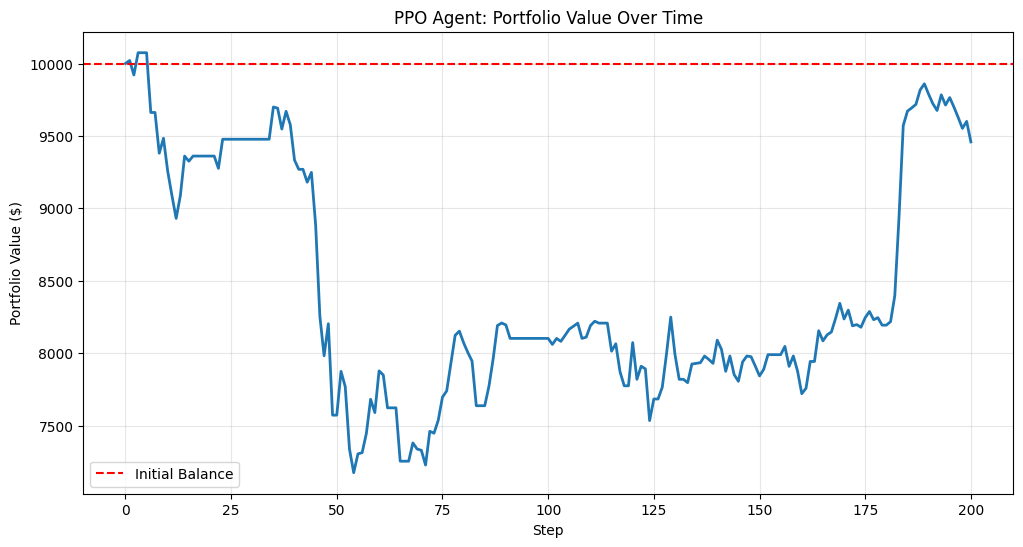

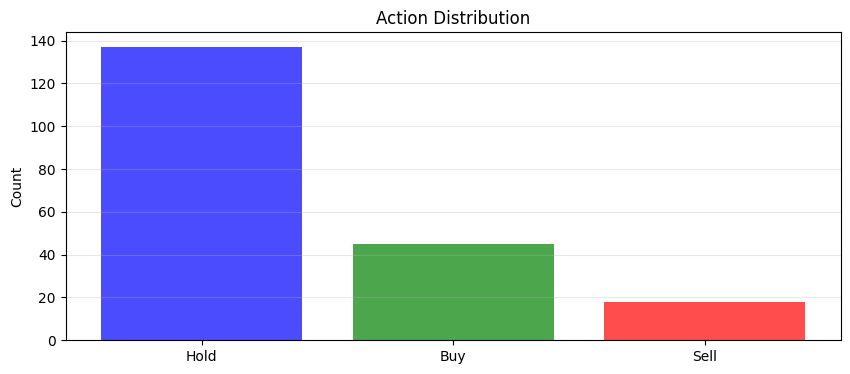

In [10]:
# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, linewidth=2)
plt.axhline(y=env.initial_balance, color='r', linestyle='--', label='Initial Balance')
plt.xlabel('Step')
plt.ylabel('Portfolio Value ($)')
plt.title('PPO Agent: Portfolio Value Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot actions distribution
plt.figure(figsize=(10, 4))
action_names = ['Hold', 'Buy', 'Sell']
action_counts = [actions_taken.count(0), actions_taken.count(1), actions_taken.count(2)]
plt.bar(action_names, action_counts, color=['blue', 'green', 'red'], alpha=0.7)
plt.ylabel('Count')
plt.title('Action Distribution')
plt.grid(True, alpha=0.3, axis='y')
plt.show()


### Compare with Random Agent


Comparing PPO vs Random agent...

Comparison:
  Random agent final value: $14141.25 (41.41%)
  PPO agent final value: $9458.93 (-5.41%)
  Improvement: $-4682.32 (-33.11%)


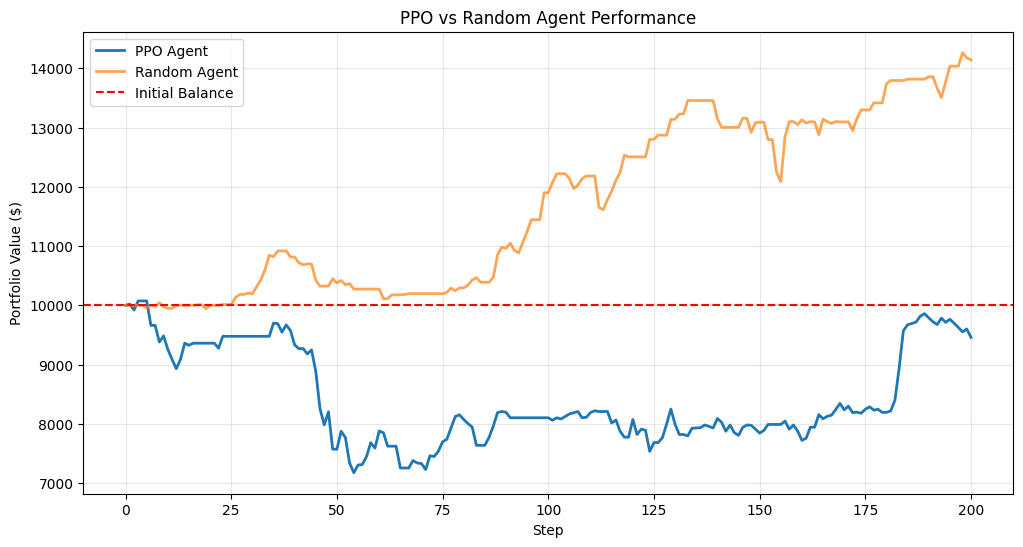

In [11]:
# Compare with random agent
print("Comparing PPO vs Random agent...\n")

# Random agent
obs, info = env.reset()
random_portfolio = [info['portfolio_value']]
random_reward = 0

for step in range(200):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    random_reward += reward
    random_portfolio.append(info['portfolio_value'])
    
    if terminated or truncated:
        break

# PPO agent (already evaluated above)
ppo_final = portfolio_values[-1]
random_final = random_portfolio[-1]

print("Comparison:")
print(f"  Random agent final value: ${random_final:.2f} ({(random_final/env.initial_balance - 1)*100:.2f}%)")
print(f"  PPO agent final value: ${ppo_final:.2f} ({(ppo_final/env.initial_balance - 1)*100:.2f}%)")
print(f"  Improvement: ${ppo_final - random_final:.2f} ({(ppo_final/random_final - 1)*100:.2f}%)")

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='PPO Agent', linewidth=2)
plt.plot(random_portfolio, label='Random Agent', linewidth=2, alpha=0.7)
plt.axhline(y=env.initial_balance, color='r', linestyle='--', label='Initial Balance')
plt.xlabel('Step')
plt.ylabel('Portfolio Value ($)')
plt.title('PPO vs Random Agent Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
